In [1]:
import dicom
import os
import numpy as np
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as py
from scipy.misc import imrotate

/root/anaconda2/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [15]:
#file_path='/opt/data/sunnybrook/challenge_online/SC-HF-I-12/IM-0103-0020.dcm'

In [2]:
#file_path2='/opt/data/sunnybrook/challenge_online/SC-HF-I-12/IM-0062-0025.dcm'

In [3]:
file_path='/opt/data/dsb/train/1/study/sax_10/IM-4562-0001.dcm'

In [23]:
#file_path='/opt/data/sunnybrook/challenge_online/SC-HF-I-11/IM-0041-0001.dcm'

Function to get the eigen vector for the image orientation

In [6]:
#Get Eigen Vectors and Values for 2D Image
def get_NewOrientation(img_array):
    y, x = np.nonzero(img_array)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    return (x_v1,y_v1), (x_v2,y_v2)

Method 1: First perfor Orientation_M1. Then do get_NewOrientation and store the output to get the eigen vectors for the image. Take Orientation_M1 output and feed it into reScale. Take reScale output and make it the input into get_square_crop. Last step is contrast. Once that is done, get the shape of the image and save that to get the new image size. 

In [4]:
#Orientation
def Orientation_M1 (img):
    if img.InPlanePhaseEncodingDirection=='COL':
        new_img=cv2.transpose(img.pixel_array)
        #py.imshow(img_new)
        new_img = cv2.flip(new_img, 0)
        return new_img
    else:
    #    print 'Row Oriented'
        return img.pixel_array

In [5]:
#Function of Rescaling the pixels after Orientation
def reScale(img, scale):
    return cv2.resize(img, (0, 0), fx=scale, fy=scale)

In [12]:
#Function of Rescaling the pixels after Orientation
def reScaleNew(img, scale):
    return cv2.resize(img, (0, 0), fx=scale[0], fy=scale[1])

In [6]:
#After Rescaling; get square crop
def get_square_crop(img, base_size=256, crop_size=256):
    res = img
    height, width = res.shape
    if height < base_size:
        diff = base_size - height
        extend_top = diff / 2
        extend_bottom = diff - extend_top
        res = cv2.copyMakeBorder(res, extend_top, extend_bottom, 0, 0, borderType=cv2.BORDER_CONSTANT, value=0)
        height = base_size

    if width < base_size:
        diff = base_size - width
        extend_top = diff / 2
        extend_bottom = diff - extend_top
        res = cv2.copyMakeBorder(res, 0, 0, extend_top, extend_bottom, borderType=cv2.BORDER_CONSTANT, value=0)
        width = base_size

    crop_y_start = (height - crop_size) / 2
    crop_x_start = (width - crop_size) / 2
    res = res[crop_y_start:(crop_y_start + crop_size), crop_x_start:(crop_x_start + crop_size)]
    return res

In [7]:
#contrast Change; perform after get_square_crop
def contrast(img):
    clahe = cv2.createCLAHE(tileGridSize=(1, 1))
    return clahe.apply(img)

In [16]:
#Method 1 Original
img=dicom.read_file(file_path)
orient=Orientation_M1(img)
rescaled=reScale(orient,img.PixelSpacing[0])
cropped=get_square_crop(rescaled)
cropped=np.array(cropped, dtype=np.uint16)
norm=contrast(cropped)

In [18]:
#Method 1 New Rescaling
new_orient=Orientation_M1(img)
new_rescaled=reScaleNew(new_orient, img.PixelSpacing)
new_cropped=get_square_crop(new_rescaled)
new_cropped=np.array(new_cropped, dtype=np.uint16)
new_norm=contrast(new_cropped)

In [19]:
#Method 1 No Orientation
no_orient_rescaled=reScaleNew(img.pixel_array, img.PixelSpacing)
no_orient_cropped=get_square_crop(no_orient_rescaled)
no_orient_cropped = np.array(no_orient_cropped, dtype=np.uint16)
no_orient_norm=contrast(no_orient_cropped)

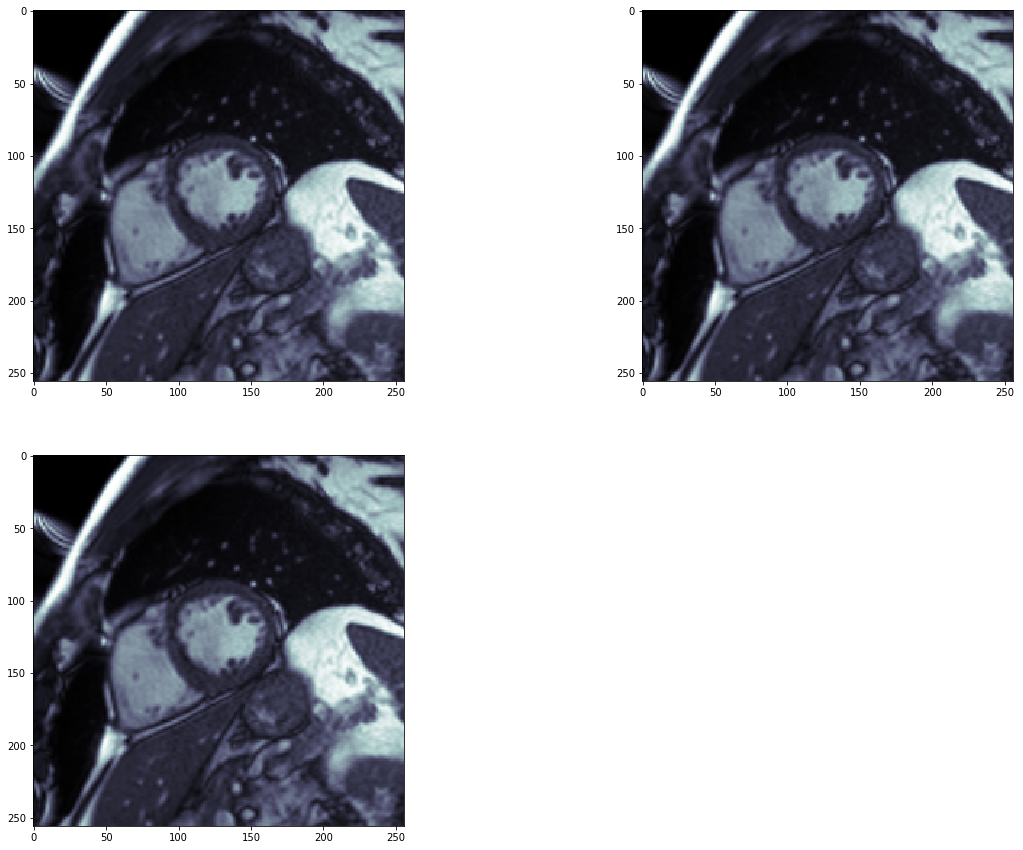

In [25]:
py.figure(figsize=(20,15))
py.subplot(221)
py.imshow(norm, cmap="bone")
py.subplot(222)
py.imshow(new_norm, cmap="bone")
py.subplot(223)
py.imshow(no_orient_norm, cmap='bone')

Method 2: Perform getAlignImg and then do get_NewOrientation and save the output. Take the output from getAlignImg and feed it into crop_size. The img_L input will be consistent for all the images. It needs to be the minimum of the most common image size for all the slices / frames. Then save the shape of the image to see if the images are the same size. 

In [27]:
#Orientation around theta and contrast normalization
def getAlignImg(t,label = None):#!!!notice, only take uint8 type for the imrotate function!!!
    f = lambda x:np.asarray([float(a) for a in x]);
    o = f(t.ImageOrientationPatient);
    o1 = o[:3];
    o2 = o[3:];
    oh = np.cross(o1,o2);
    or1 = np.asarray([0.6,0.6,-0.2]);
    o2new = np.cross(oh,or1);
    theta = np.arccos(np.dot(o2,o2new)/np.sqrt(np.sum(o2**2)*np.sum(o2new**2)))*180/3.1416;
    theta = theta * np.sign(np.dot(oh,np.cross(o2,o2new)));
    im_max = np.percentile(t.pixel_array.flatten(),99);
    res = imrotate(np.array(np.clip(np.array(t.pixel_array,dtype=np.float)/im_max*256,0,255),dtype=np.uint8),theta);
    if label is None:
        return res;
    else:
        lab = imrotate(label,theta);
        return res,lab

In [41]:
def contrast(img):
    im_max=np.percentile(img.flatten(),99)
    res = np.array(np.clip(np.array(img,dtype=np.float)/im_max*256,0,255),dtype=np.uint8)
    return res

In [28]:
img_L=int(np.min(180)) #NEEDS to be the most common minimum image shape for all the slices

In [29]:
def crop_size(res, img_L):
    shift  = np.array([0,0]) 
    if res.shape[0]>res.shape[1]:
        s = (res.shape[0]-res.shape[1])//2;
        res = res[s:s+res.shape[1],:];
        shift[1] = s;
    else:
        s = (res.shape[1]-res.shape[0])//2;
        res = res[:,s:s+res.shape[0]];
        shift[0] = s;

        #crop or stretch to the same size
    if img_L>0 and (res.shape[0] != img_L):
        #print("crop or fill",filename);
        if res.shape[0]>img_L:#because h=w after crop
            s = (res.shape[0]-img_L)//2;
            res = res[s:s+img_L,s:s+img_L];
            shift = shift + s;
        else:
            s = (img_L-res.shape[0])//2;
            res2 = np.zeros((self.img_L,img_L));
            res2[s:s+res.shape[0],s:s+res.shape[0]] = res;
            res = res2;
            shift = shift - s;
    return res

In [32]:
#Method 2 Original
step1=getAlignImg(img)
step2=crop_size(step1, img_L)

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  del sys.path[0]


In [35]:
#Method 2 with Rescaling
new_step1=getAlignImg(img)
m2rescaled=reScaleNew(new_step1, img.PixelSpacing)
new_step2=crop_size(new_step1, img_L)

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  del sys.path[0]


In [46]:
#Metod 2 with No Orientation
no_orient_m2rescaled=reScaleNew(img.pixel_array, img.PixelSpacing)
m2Contrast=contrast(no_orient_m2rescaled)
no_orient_m2step2=crop_size(m2Contrast, img_L)

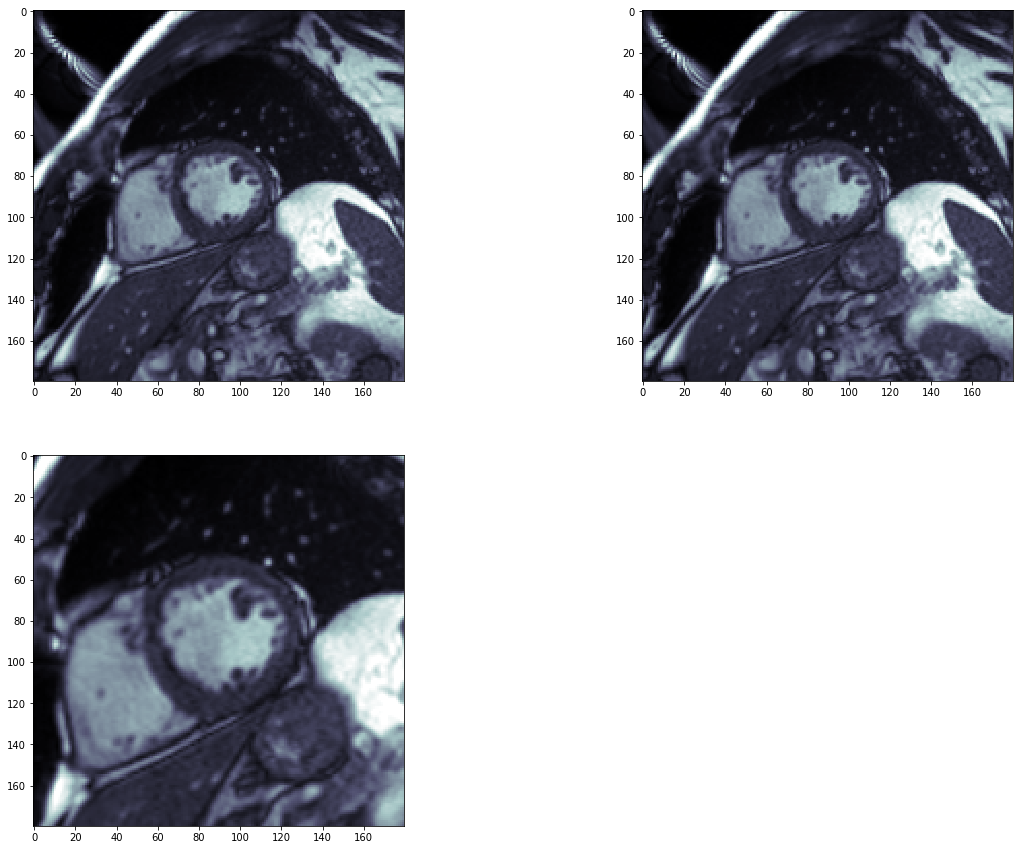

In [47]:
py.figure(figsize=(20,15))
py.subplot(221)
py.imshow(step2, cmap="bone")
py.subplot(222)
py.imshow(new_step2, cmap="bone")
py.subplot(223)
py.imshow(no_orient_m2step2, cmap='bone')

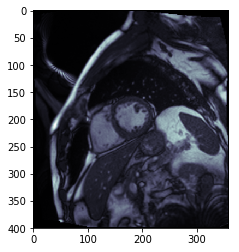

In [48]:
#Only Rescaling
rescaled_only=reScaleNew(img.pixel_array, img.PixelSpacing)
py.imshow(rescaled, cmap='bone')